<a id="header"></a>
<center><p style="background:#DFDFDF; font-family:Arial; font-weight:bold; font-size:250%; color:black; text-align:center; width:100%; padding:50px">Rice Classification with CNNs</p></center>

<a id="import"></a>
<center><p style="background:#DFDFDF url('pylogo.jpg') no-repeat; font-family:Courier; font-size:200%; color:black; text-align:center; width:80%; padding:30px">Importing Libraries</p></center>

In [1]:
# Linear Algebra
import numpy as np

# Image Visualisation
import matplotlib.pyplot as plt

# Model Building + Training
import tensorflow as tf

# Clearing Memory
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import gc

# Operating system
import os

In [2]:
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it does something you should see a number as output

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

<a id="import"></a>
<center><p style="background:#DFDFDF url('pylogo.jpg') no-repeat; font-family:Courier; font-size:200%; color:black; text-align:center; width:80%; padding:30px">Train-Val-Test Split</p></center>

The split-folders library split folders with files (e.g. images) into train, validation and test (dataset) folders from this format: 
<pre>

input/
    class1/
        img1.jpg
        img2.jpg
        ...
    class2/
        imgWhatever.jpg
        ...
    ...

</pre>

Into this format:

<pre>

output/
    train/
        class1/
            img1.jpg
            ...
        class2/
            imga.jpg
            ...
    val/
        class1/
            img2.jpg
            ...
        class2/
            imgb.jpg
            ...
    test/
        class1/
            img3.jpg
            ...
        class2/
            imgc.jpg
            ...

</pre>

In [3]:
# Adjust base directory according to your file path
base_dir = "Rice_Image_Dataset\\"

In [4]:
!pip install split-folders

In [6]:
import splitfolders

# Splits all images into Train, Test Validation
# Takes a while to run! Depends on processing power
if (os.path.exists("output") == False):
    splitfolders.ratio(base_dir, output="output",seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

In [7]:
output_dir = "output\\"

# Setting the directories for our Train, val and test folders
train_dir = os.path.join(output_dir, "train")
print("Train directory: ", train_dir)

val_dir = os.path.join(output_dir, "val")
print("Validation directory: ", val_dir)

test_dir = os.path.join(output_dir, "test")
print("Test directory: ", test_dir)

Train directory:  output\train
Validation directory:  output\val
Test directory:  output\test


<a id="import"></a>
<center><p style="background:#FE7171 url('pylogo.jpg') no-repeat; font-family:Courier; font-size:200%; color:black; text-align:center; width:80%; padding:30px">Loading our Data (Deprecated)</p></center>

To load our data, we will be using Tensorflow's ImageDataGenerator. ImageDataGenerator allows to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors.

ImageDataGenerator provides options for adjusting your data, including data augmentation, resizing images, downscaling, and more.

Read more [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

Initially, we will assess the model's performance using our original data, without applying data augmentation. Therefore, our focus will be on downscaling the data.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load 2 instances of ImageDataGenerator. One for our train set, and one for test set
# We do not need one for Validation, as it works the same way as our test set
train_datagen = ImageDataGenerator(rescale =1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

"""
The flow_from_directory function accepts a directory path and generates data batches. 
It provides options to resize images, specify the color mode, set the class_mode (e.g., binary or categorical), 
define the batch size, and etc.

"""
train_generator = train_datagen.flow_from_directory(train_dir, # Train Directory
                                                    target_size=(250, 250), # Image size 250x250px
                                                    color_mode='rgb', # 3 channels: R, G, B
                                                    class_mode='categorical', # 5 classes, so categorical
                                                    batch_size=32) # Set 32 as our batch size

# Repeat process for validation set
validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size=(250, 250), 
                                                        color_mode='rgb', 
                                                        class_mode='categorical',
                                                        batch_size=32) 

Found 60000 images belonging to 5 classes.
Found 7500 images belonging to 5 classes.


<a id="import"></a>
<center><p style="background:#DFDFDF url('pylogo.jpg') no-repeat; font-family:Courier; font-size:200%; color:black; text-align:center; width:80%; padding:30px">Loading our Data</p></center>

To load our dataset into your notebook, we can utilize TensorFlow's `image_dataset_from_directory` function. This function is used to create a `tf.data.Dataset` object from image files stored in a directory structure. 

The resulting `tf.data.Dataset` object provides batches of images from the subdirectories of your classes, along with corresponding labels that indicate the class for each image. This makes it convenient for training and working with image datasets in TensorFlow.

Full documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

In [9]:
from keras.utils import image_dataset_from_directory

# Batch size and Image size definition
BATCH_SIZE = 32
IMAGE_SIZE = 250

# Loading our train set
train_ds = image_dataset_from_directory(train_dir,
                                        seed=123,
                                        image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size=BATCH_SIZE)    

# Loading our validation set
validation_ds = image_dataset_from_directory(val_dir,
                                             seed=123,
                                             image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=BATCH_SIZE)  

Found 60000 files belonging to 5 classes.
Found 7500 files belonging to 5 classes.


In [10]:
# Retrieving our class names
class_names = train_ds.class_names

print(class_names)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


<a id="import"></a>
<center><p style="background:#DFDFDF url('pylogo.jpg') no-repeat; font-family:Courier; font-size:200%; color:black; text-align:center; width:80%; padding:30px">Scaling our Data</p></center>

In [11]:
from keras.layers import Rescaling

# Instantiate our Rescaler
# Image range will be downscaled from 0-255 to 0-1
normalization_layer = Rescaling(1./255)

# Rescaling our images using the .map function
# Labels are unaffected 
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = validation_ds.map(lambda x, y : (normalization_layer(x), y))

In [12]:
# Verifying that our images our now scaled
image_batch_train, labels_batch_train = next(iter(train_ds)) # Get first batch 
first_image_train = image_batch_train[0] # First Image, of first batch

image_batch_val, labels_batch_val = next(iter(validation_ds))
first_image_val = image_batch_val[0]

print("Train scale: ", np.min(first_image_train), np.max(first_image_train))
print("Validation scale: ", np.min(first_image_val), np.max(first_image_val))

Train scale:  0.0 1.0
Validation scale:  0.0 1.0


<a id="import"></a>
<center><p style="background:#DFDFDF url('pylogo.jpg') no-repeat; font-family:Courier; font-size:200%; color:black; text-align:center; width:80%; padding:30px">Visualising our Rice!</p></center>

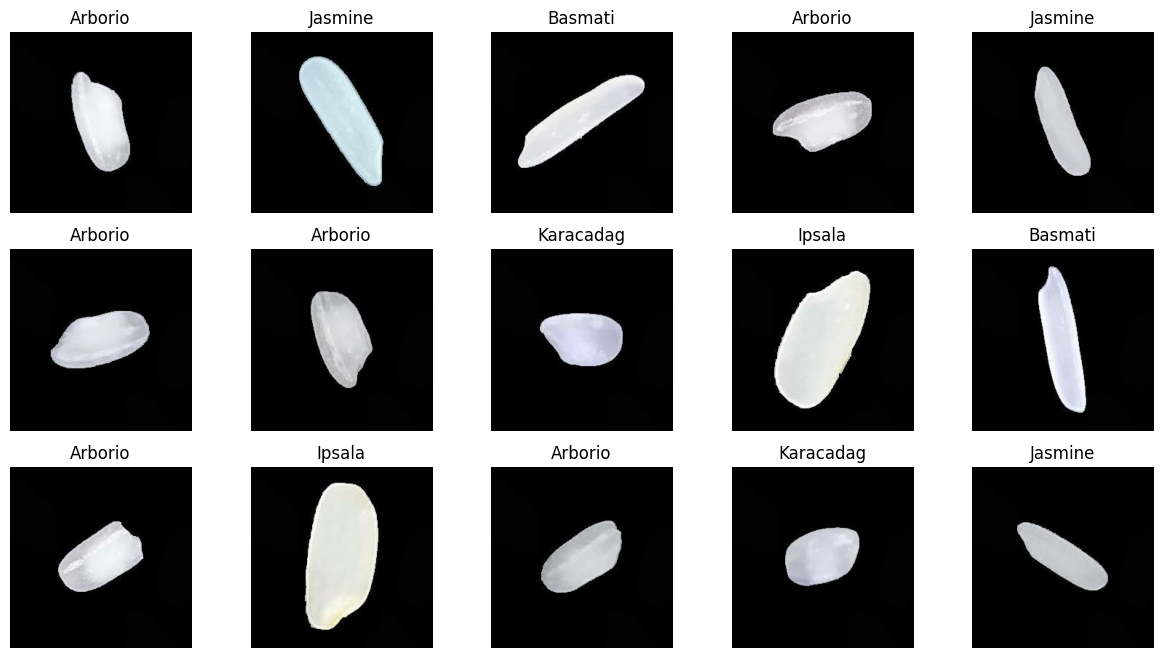

In [22]:
# Create our figure
fig, axes = plt.subplots(3, 5, figsize=(15, 8))

# Take images from first batch, and plot
for images, labels in train_ds.take(1):
  for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i])
    ax.set_title(class_names[labels[i]])
    ax.axis("off")

Visualizing the data is a crucial step in the data preprocessing pipeline as it helps us understand the reasoning behind the preprocessing choices we make. For instance, when working with images of rice, it might be a common assumption that rice grains are predominantly white against a black background. However, by keeping the color mode as RGB, we acknowledge that the shades of white for different rice breeds can vary significantly.

<a id="import"></a>
<center><p style="background:#DFDFDF url('pylogo.jpg') no-repeat; font-family:Courier; font-size:200%; color:black; text-align:center; width:80%; padding:30px">Building our FIRST model</p></center>

In [25]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [40]:
model_base = Sequential(name="base_model")

model_base.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model_base.add(layers.MaxPooling2D((2, 2)))

model_base.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_base.add(layers.MaxPooling2D((2, 2)))

model_base.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_base.add(layers.MaxPooling2D((2, 2)))

model_base.add(layers.Flatten())

model_base.add(layers.Dense(32, activation='relu'))

model_base.add(layers.Dense(5, activation='softmax'))

model_base.summary()

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 124, 124, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 29, 29, 128)      0

In [48]:
model_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                   loss= tf.keras.losses.SparseCategoricalCrossentropy(), 
                   metrics=["acc"])

In [49]:
EPOCHS = 5

history_base = model_base.fit(train_ds, validation_data=validation_ds, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 72s 35ms/step - loss: 0.1316 - acc: 0.9542 - val_loss: 0.0838 - val_acc: 0.9724
Epoch 2/5
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0770 - acc: 0.9737 - val_loss: 0.0672 - val_acc: 0.9780
Epoch 3/5
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0550 - acc: 0.9812 - val_loss: 0.0514 - val_acc: 0.9809
Epoch 4/5
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0415 - acc: 0.9856 - val_loss: 0.0476 - val_acc: 0.9828
Epoch 5/5
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0292 - acc: 0.9904 - val_loss: 0.0461 - val_acc: 0.9844
